# Transfroming the Dicom Scans inton PNGs and collecting them in a folder

In [2]:
import os
import shutil
import pydicom
from PIL import Image
from pydicom.errors import InvalidDicomError

def extract_number(filename):
    number_part = ''.join(filter(str.isdigit, filename))
    return int(number_part) if number_part else 0

def extract_dicom_parameters(dicom_path):
    try:
        dicom_file = pydicom.dcmread(dicom_path)
        pixel_spacing = dicom_file.PixelSpacing if "PixelSpacing" in dicom_file else "Not available"
        slice_thickness = dicom_file.SliceThickness if "SliceThickness" in dicom_file else "Not available"
        return pixel_spacing, slice_thickness
    except Exception as e:
        return str(e), None

def dicom_folder_to_png(dicom_folder, print_progress=True, print_parameters=True):
    output_folder = "PNGS_Final"

    # Check if the output folder exists and delete it
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)

    # Create a new empty output folder
    os.makedirs(output_folder, exist_ok=True)

    dicom_files = sorted([f for f in os.listdir(dicom_folder)], key=extract_number)
    dicom_parameters = None

    for idx, dicom_file in enumerate(dicom_files):
        dicom_path = os.path.join(dicom_folder, dicom_file)

        if print_progress:
            print(f"Converting {dicom_path}...")

        try:
            with pydicom.dcmread(dicom_path) as ds:
                # Extract DICOM parameters only once
                if dicom_parameters is None and print_parameters:
                    dicom_parameters = extract_dicom_parameters(dicom_path)
                    print(f"DICOM Parameters (Pixel Spacing, Slice Thickness): {dicom_parameters}")

                pixel_data = ds.pixel_array
                normalized_pixel_data = ((pixel_data - pixel_data.min()) / (pixel_data.max() - pixel_data.min()) * 255).astype('uint8')
                img = Image.fromarray(normalized_pixel_data, mode='L')
                dpi = 512
                png_file = os.path.join(output_folder, f"{idx + 1:03d}.png")
                img.save(png_file, "PNG", dpi=(dpi, dpi))
                
                if print_progress:
                    print(f"Saved {png_file}")

        except InvalidDicomError:
            if print_progress:
                print(f"Skipped non-DICOM file: {dicom_file}")

dicom_folder = "AXIAL"
dicom_folder_to_png(dicom_folder, print_progress=False, print_parameters=True)


DICOM Parameters (Pixel Spacing, Slice Thickness): ([0.415, 0.415], '0.833')


# Classifying the Trackers into Clusters

In [16]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

def find_circles(image_path, display=False):
    # Read image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    
    # Adjust the brightness of the image
    brightness_factor = 2
    enhanced_img = cv2.convertScaleAbs(img, alpha=brightness_factor, beta=0)

    # Convert the enhanced image to grayscale
    gray = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2GRAY)

    # Binarize the grayscale image
    _, binary_image = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

    # Fill in the shapes (contours) in the binary image
    binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize a list to store valid circles
    valid_circles = []

    for contour in contours:
        # Calculate the area and perimeter for each contour
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)

        # Skip contour if the perimeter is zero (to avoid division by zero)
        if perimeter == 0:
            continue

        # Calculate the circularity for each contour
        circularity = 4 * np.pi * area / (perimeter * perimeter)

        # Define circularity and area thresholds to filter circles
        circularity_threshold = 0.8  # Adjust this threshold as needed
        min_area = 100  # Adjust this threshold as needed
        max_area = 2000

        # Check if the contour meets the circularity and area criteria
        if circularity >= circularity_threshold and max_area >= area >= min_area:
            # Fit a circle to the contour and obtain its center (a, b) and radius (r)
            (a, b), r = cv2.minEnclosingCircle(contour)
            a, b, r = int(a), int(b), int(r)
            valid_circles.append((a, b, r))
            
            if display:
                print(f"Circle: Center ({a}, {b}), Slice # {r}, Circularity {circularity}")
                # Draw the circumference of the circle on the image
                cv2.circle(img, (a, b), r, (255, 100, 255), 2)
                # Draw a small circle at the center
                cv2.circle(img, (a, b), 1, (255, 0, 0), 2)

    # Display the image with circles drawn if display is True
    if valid_circles and display:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert to RGB for displaying
        plt.show()

    return valid_circles


def cluster_trackers(png_files, threshold=10, display=False, show_images=False):
    all_circles = []

    for idx, png_file in enumerate(png_files):
        png_path = os.path.join(pngs_folder, png_file)
        circles = find_circles(png_path, display=display)

        if circles is not None:
            for circle in circles:
                all_circles.append((circle[0], circle[1], idx))  # x, y, z

    clusters = {}
    for circle in all_circles:
        added_to_cluster = False
        for cluster_id, cluster_circles in clusters.items():
            if all(np.linalg.norm(np.array(circle[:2]) - np.array(c[:2])) < threshold for c in cluster_circles):
                cluster_circles.append(circle)
                added_to_cluster = True
                break

        if not added_to_cluster:
            clusters[len(clusters)] = [circle]

    final_clusters = {}
    for cluster_id, cluster_circles in clusters.items():
        if len(cluster_circles) >= 6:
            # Sort the cluster circles based on the slice number (z-coordinate)
            sorted_circles = sorted(cluster_circles, key=lambda x: x[2])

            # Find the two median slices
            mid_index = len(sorted_circles) // 2
            median_circles = sorted_circles[mid_index - 1: mid_index + 1]

            # Compute the average coordinates of the two median circles
            avg_x = np.mean([c[0] for c in median_circles])
            avg_y = np.mean([c[1] for c in median_circles])
            avg_z = np.mean([c[2] for c in median_circles])
            final_clusters[cluster_id] = (avg_x, avg_y, avg_z)

            # Rest of the code remains the same...

    return final_clusters


# Folder containing PNG files
pngs_folder = 'PNGS_Final'

# List PNG files in the folder
png_files = [f for f in os.listdir(pngs_folder) if f.lower().endswith('.png')]

# Cluster the trackers with the option to show images
tracker_clusters = cluster_trackers(png_files, display=False, show_images=False)

for cluster_id, coordinates in tracker_clusters.items():
    print(f"Cluster {cluster_id}: Average Coordinates: {coordinates}")

Cluster 0: Average Coordinates: (286.0, 301.0, 3.5)
Cluster 1: Average Coordinates: (268.0, 260.0, 105.5)
Cluster 2: Average Coordinates: (374.0, 375.0, 22.5)
Cluster 3: Average Coordinates: (203.0, 396.5, 37.5)
Cluster 5: Average Coordinates: (332.0, 479.0, 55.5)
Cluster 8: Average Coordinates: (375.5, 339.0, 105.5)
Cluster 9: Average Coordinates: (198.0, 308.0, 147.5)
Cluster 11: Average Coordinates: (285.0, 428.0, 171.5)


# Grouping The Clusters Into 2 Trackers

Enter shape for Tracker 1 (1 or 2): 1
Enter shape for Tracker 2 (1 or 2): 2


<IPython.core.display.Javascript object>


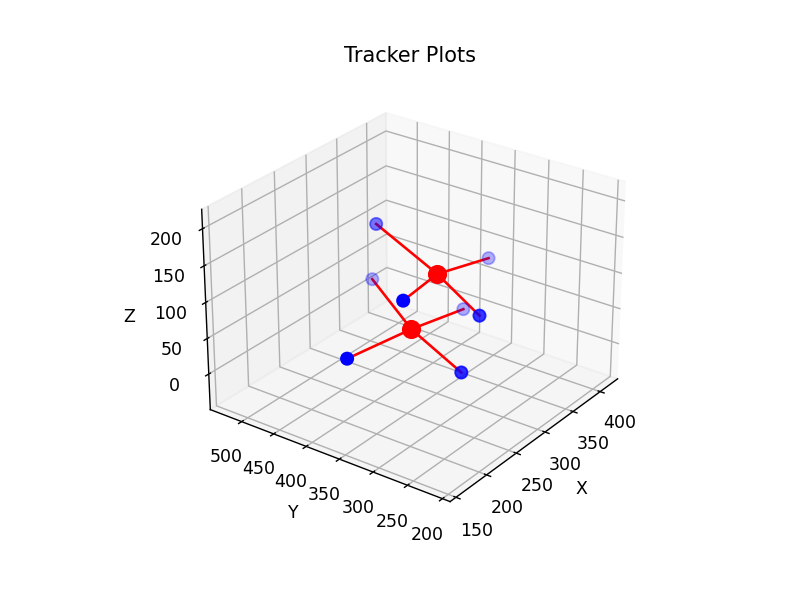

In [34]:
%matplotlib notebook
import numpy as np
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the known tracker shapes
tracker_shapes = {
    "1": [
        (0.00, 0.00, 0.00),
        (0.00, 28.59, 41.02),
        (0.00, 0.00, 88.00),
        (0.00, -44.32, 40.45)
    ],
    "2": [
        (0.00, 0.00, 0.00),
        (0.00, 47.38, 28.99),
        (0.00, 0.00, 89.10),
        (0.00, -35.36, 35.36)
    ]
}

def distance(p1, p2):
    """Calculate the Euclidean distance between two points."""
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2)

def classify_tracker_balls(tracker_balls, shape, tracker_id):
    """
    Classify each ball of the tracker based on the chosen shape.
    """
    classified_trackers = []

    # Iterate over all combinations of 4 balls
    for combination in itertools.combinations(tracker_balls, 4):
        distances = [distance(combination[i], shape[j]) for i in range(4) for j in range(4)]
        if all(d < threshold for d in distances):
            classified_trackers.append({
                "balls": [{"id": f"Tracker_{tracker_id}_ball_{i+1}", "coordinates": ball} for i, ball in enumerate(combination)],
                "shape": shape
            })

    return classified_trackers

# Extract the coordinates
tracker_balls = [coordinates for _, coordinates in tracker_clusters.items()]

# Determine the number of trackers
num_trackers = len(tracker_balls) // 4

classified_trackers = []
for i in range(1, num_trackers + 1):
    # User input for each tracker shape
    user_choice = input(f"Enter shape for Tracker {i} (1 or 2): ")
    chosen_shape = tracker_shapes[user_choice]

    # Classify the tracker balls
    classified_tracker = classify_tracker_balls(tracker_balls, chosen_shape, i)
    classified_trackers.extend(classified_tracker)

# Print the details of each tracker
for tracker in classified_trackers:
    print(f"Tracker {tracker['balls'][0]['id'].split('_')[1]}:")
    for ball in tracker['balls']:
        print(f"{ball['id']}: {ball['coordinates']}")
    print(f"Shape: {tracker['shape']}")
    
def calculate_centroid(points):
    """Calculate the centroid of a set of points."""
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    z_coords = [p[2] for p in points]
    centroid = (np.mean(x_coords), np.mean(y_coords), np.mean(z_coords))
    return centroid

def plot_trackers(trackers):
    """
    Plot multiple trackers with their balls in 3D.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for tracker in trackers:
        # Extract coordinates for plotting
        x_coords = [ball[0] for ball in tracker['balls']]
        y_coords = [ball[1] for ball in tracker['balls']]
        z_coords = [ball[2] for ball in tracker['balls']]

        # Plot the balls
        ax.scatter(x_coords, y_coords, z_coords, color='b', s=50)

        # Calculate and plot centroid
        centroid = calculate_centroid(tracker['balls'])
        ax.scatter(*centroid, color='r', s=100)

        # Connect each ball to the centroid
        for x, y, z in zip(x_coords, y_coords, z_coords):
            ax.plot([centroid[0], x], [centroid[1], y], [centroid[2], z], color='r')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title("Tracker Plots")
    plt.show()

# Make plot interactive
plt.ion()

# Plot each tracker
plot_trackers(grouped_trackers)